In [19]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost
from xgboost import XGBClassifier


from sklearn.metrics import confusion_matrix, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

from sklearn.pipeline import Pipeline

import pickle
import joblib
import json


- **danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. 

- **energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. 

- **key**: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C?/D?, 2 = D, and so on. If no key was detected, the value is -1.

- **loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. 

- **mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

- **speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. 

- **acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. The distribution of values for this feature look like this:

- **instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. The distribution of values for this feature look like this:

- **liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

- **valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

- **tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. 

- **duration_ms**:  The duration of the track in milliseconds.

- **time_signature**: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

- **chorus_hit**: This the the author's best estimate of when the chorus would start for the track. Its the timestamp of the start of the third section of the track. This feature was extracted from the data received by the API call for Audio Analysis of that particular track.

- **sections**: The number of sections the particular track has. This feature was extracted from the data received by the API call for Audio Analysis of that particular track.


#### identifier : 'id', 'track', 'uri'
#### range: 0-1 :
    * 'danceability', 
    * 'energy', 
    * 'acousticness' (confidence score) (metal electric is opposite of acoustic)
    * 'liveness'(0.8+ value means audio is likely live), 
    * 'speechiness'( 0-0.33 more music, 0.33-0.66 combination of words and music and above 0.66 speech, talk etc)
    * 'instrumentalness' (Is it inverse of speechiness ???)
    * 'valence' (musical sentiment high-positive(happy, cheerful, euphoric), low-negative(sad, angry, depressed) 
#### 'key',: pitch class (confusion - categorical or non categorical)
#### 'mode': binary 0 and 1  major minor
#### continuous variables:
    * 'tempo': beats per min
    * 'loudness':  -60 to 0 decibels
    * 'duration_ms': length
    * 'time_signature': beats in each bar in m
    * 'chorus_hit', 
    * 'sections'
#### Categorical decade version :00's,  60's... etc

In [3]:
spotify_data= pd.read_csv("wm_project.csv").set_index('id')
# storing identification information in a dictionary to be reused if required
audio_track_info = spotify_data.T.to_dict()

with open('audio_track_info.json', 'w') as outfile:
    json.dump(audio_track_info, outfile)

# Removing identification data from the train and test 
spotify_data = spotify_data.drop(['uri','track'],axis = 1)

# Setting aside test data 
x_test = spotify_data[spotify_data.hit.isna()].drop("hit", axis=1)


In [4]:
x_test.to_csv("test_data.csv")

### Exploratory Data Analysis:


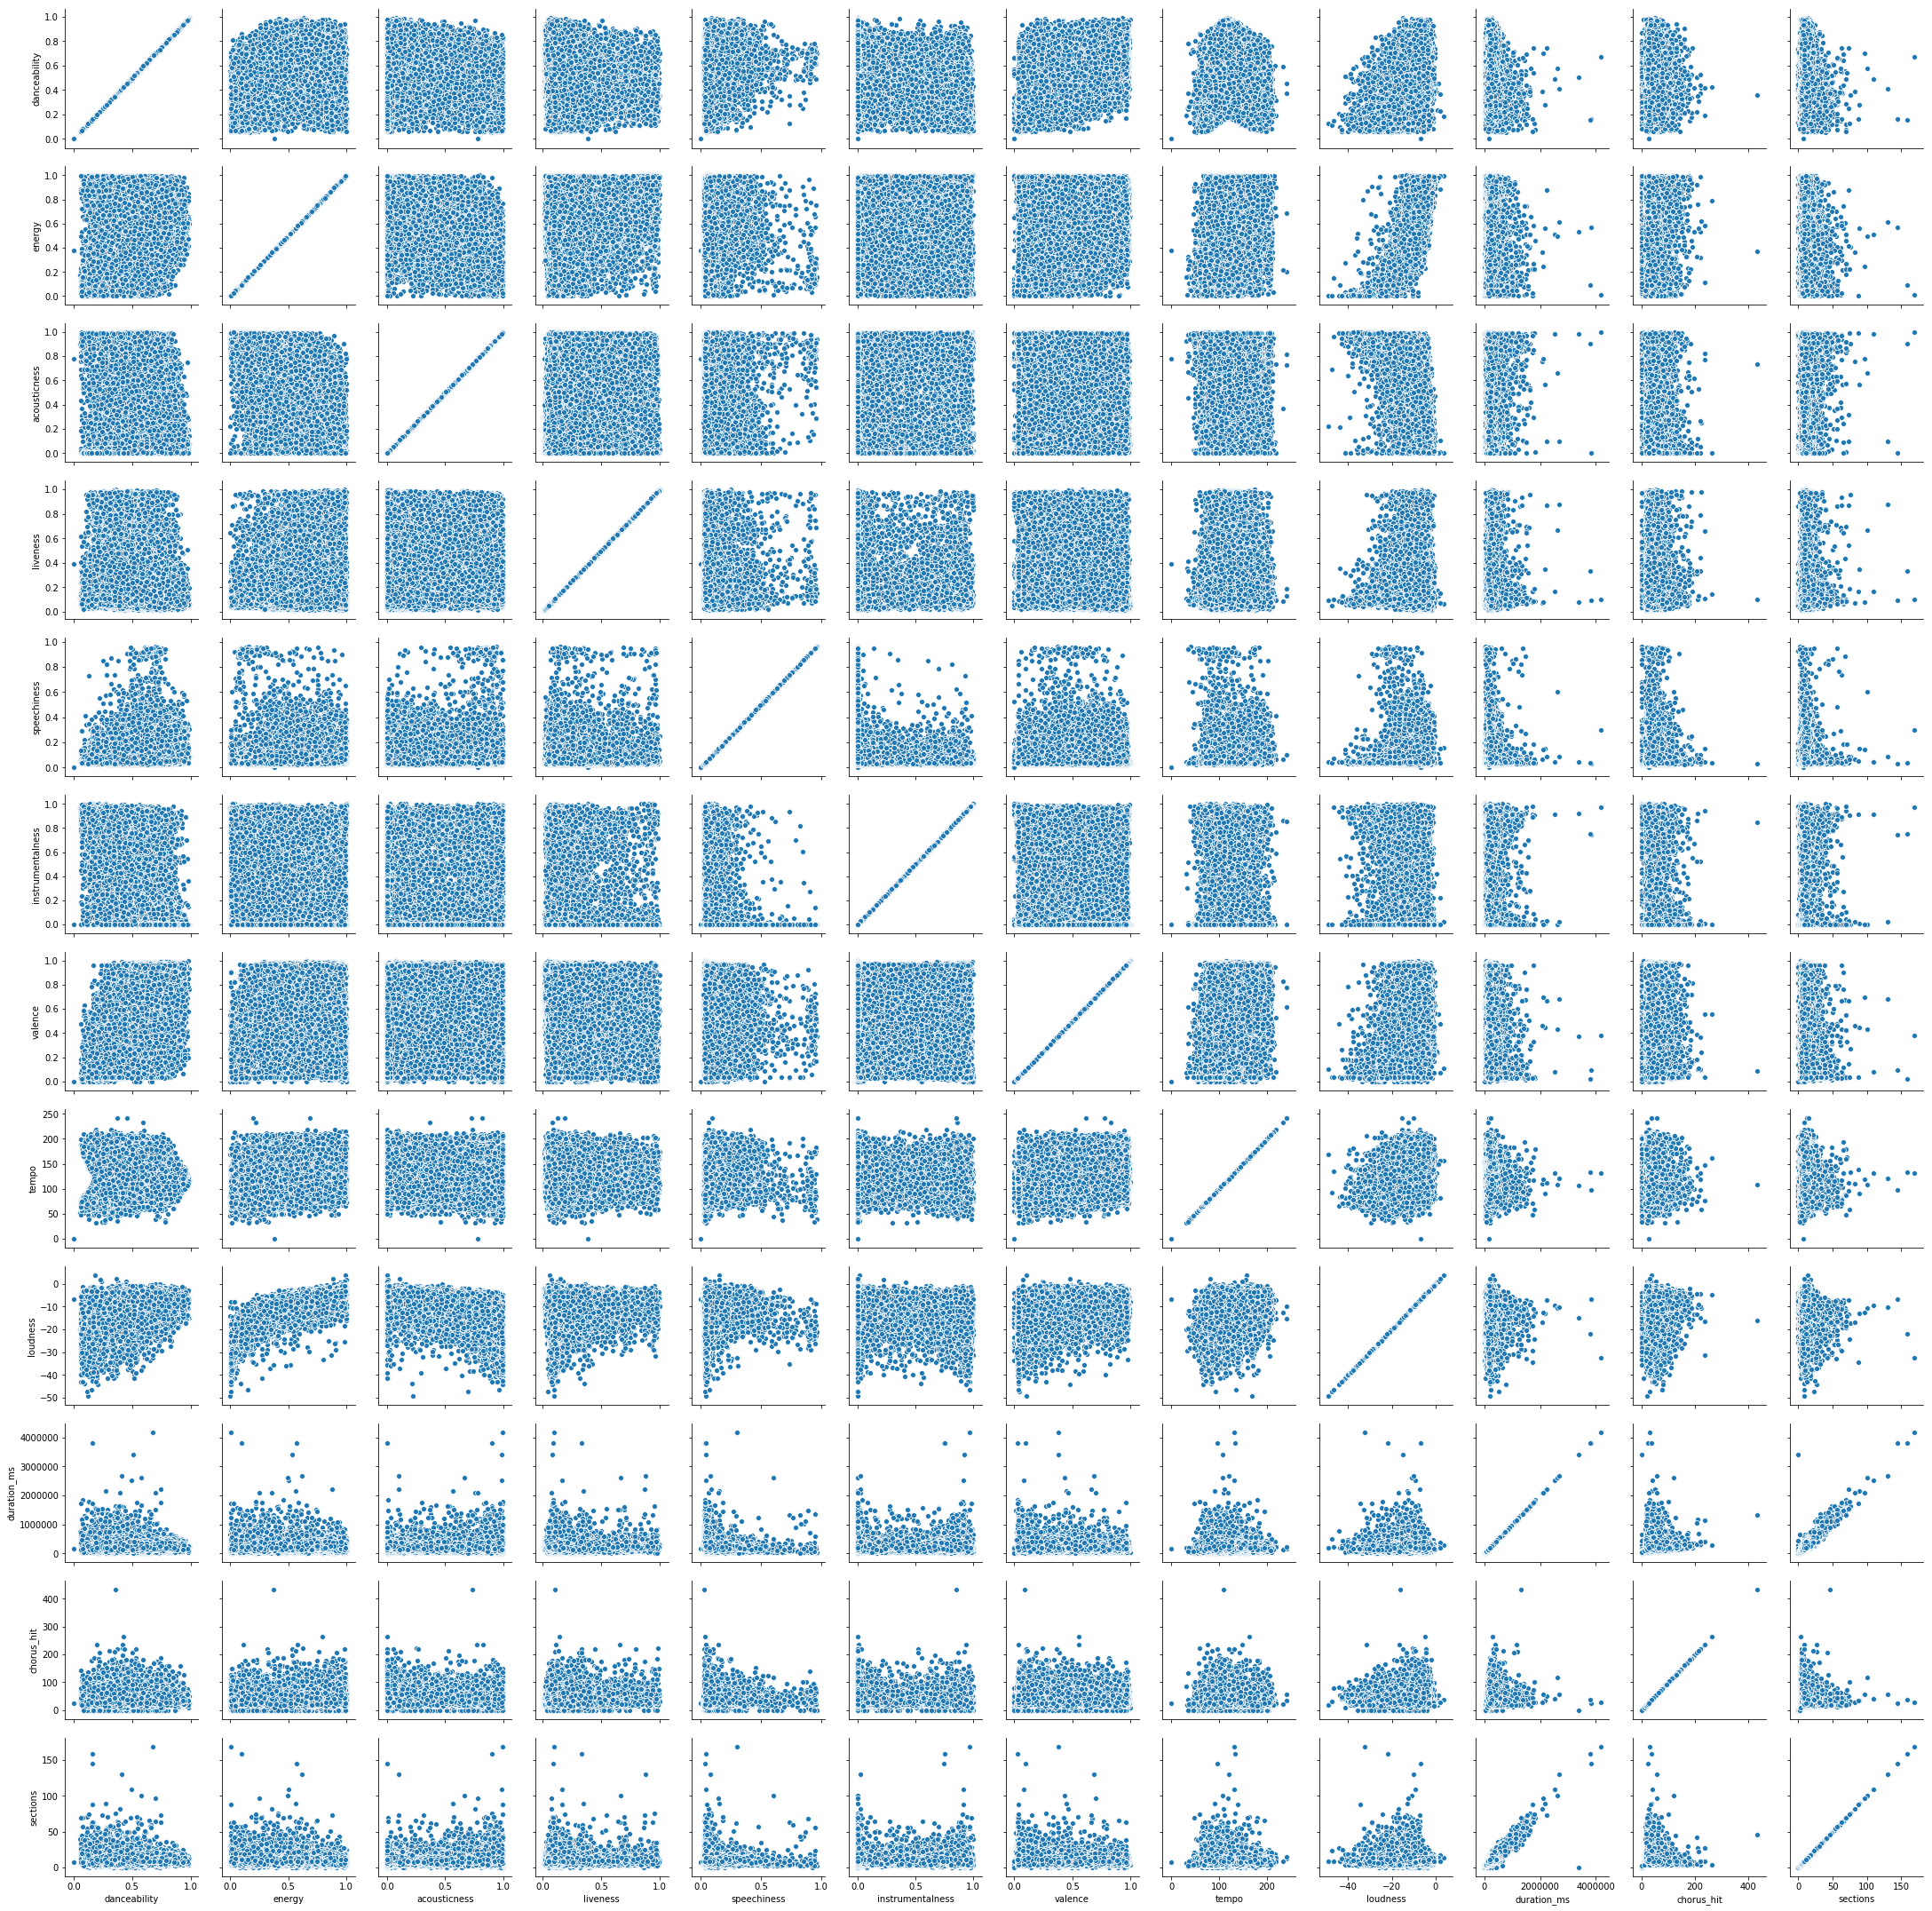

In [5]:
g = sns.PairGrid(spotify_data[['danceability','energy','acousticness','liveness','speechiness','instrumentalness','valence','tempo','loudness','duration_ms','chorus_hit','sections']])
g.map(sns.scatterplot)


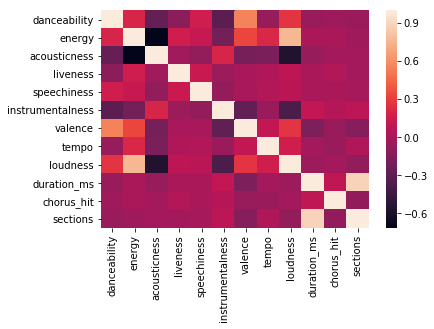

In [6]:
correlation = spotify_data[['danceability','energy','acousticness','liveness','speechiness','instrumentalness','valence','tempo','loudness','duration_ms','chorus_hit','sections']].corr()
sns.heatmap(correlation)

##### Initial observations
* Loudness and energy are inversely related to acousticness. 
* Loudness and energy are correlated.
* Valence and danceability also have correlation.

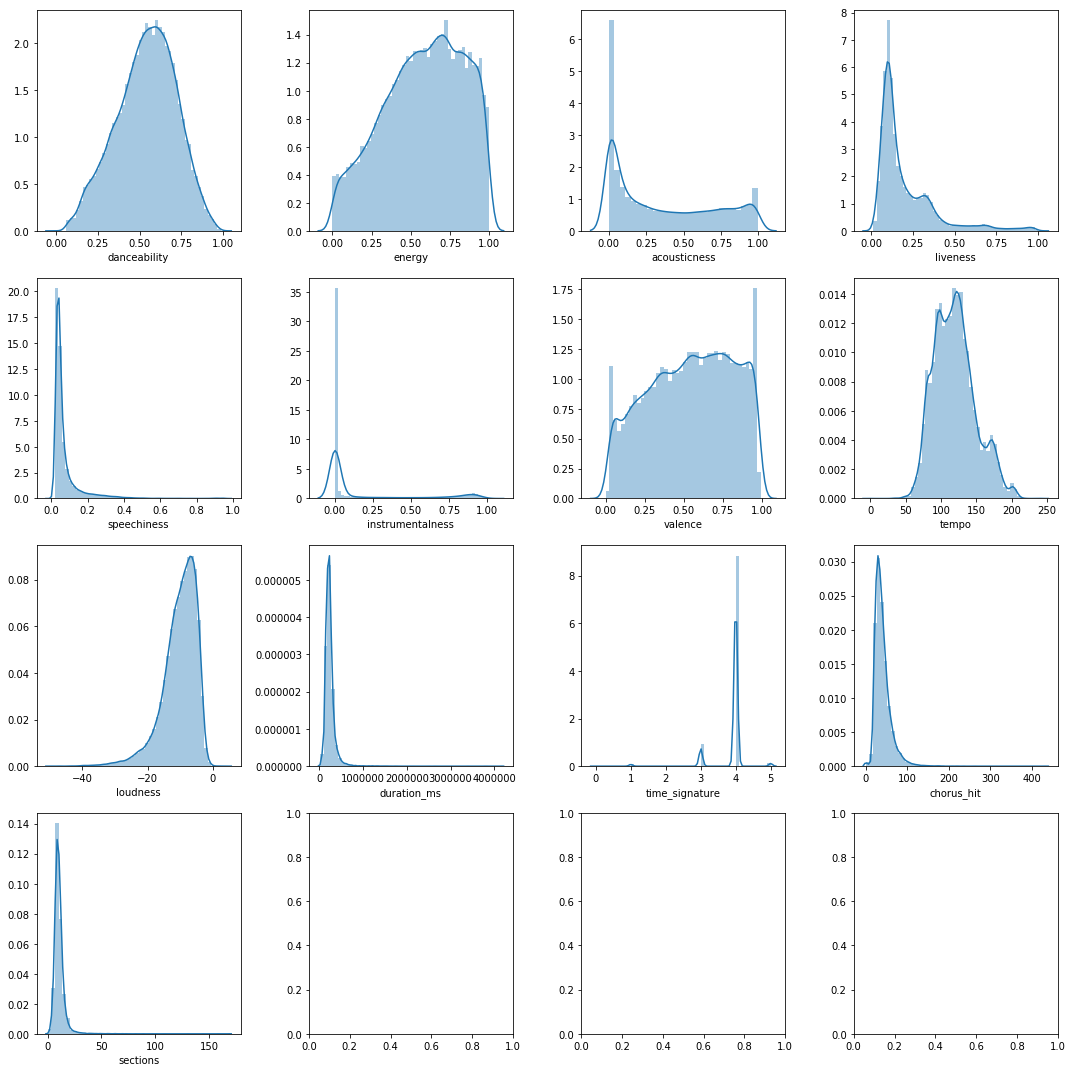

In [7]:
cols = ['danceability','energy','acousticness','liveness','speechiness',\
        'instrumentalness','valence','tempo','loudness','duration_ms',\
        'time_signature','chorus_hit','sections']

fig, axes = plt.subplots(nrows = 4, ncols = 4)    # axes is 2d array (3x3)
axes = axes.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(15, 15)

for ax, col in zip(axes, cols):
    sns.distplot(spotify_data[col], ax=ax)
    plt.tight_layout() 
plt.show()
        

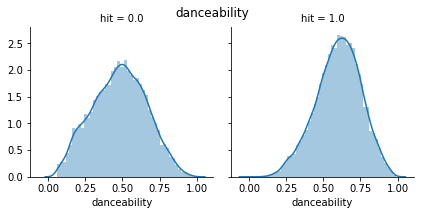

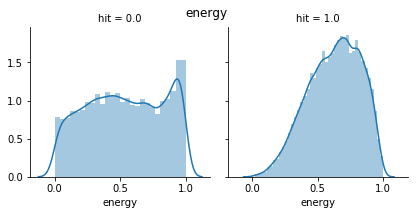

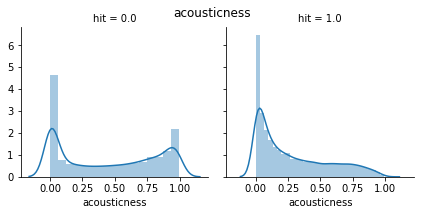

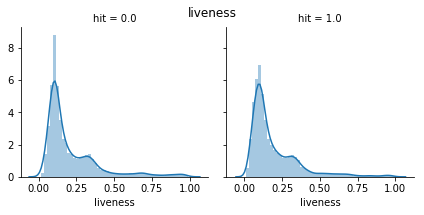

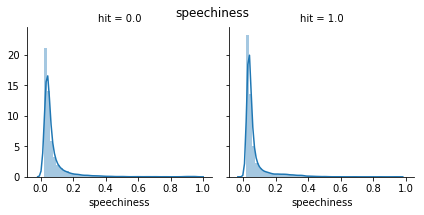

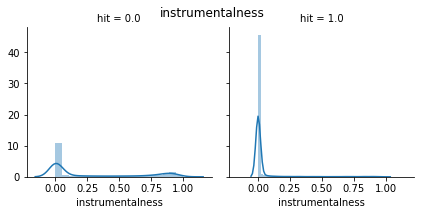

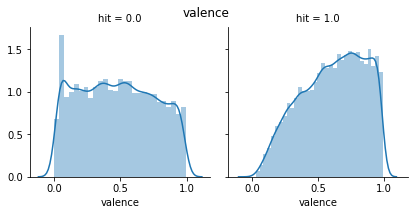

In [8]:
for i in ['danceability','energy','acousticness','liveness','speechiness','instrumentalness','valence']:
    g = sns.FacetGrid(spotify_data, col="hit")
    g.map(sns.distplot, i)
    g.fig.suptitle(i)


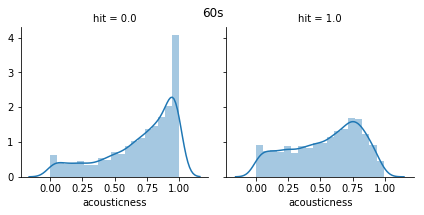

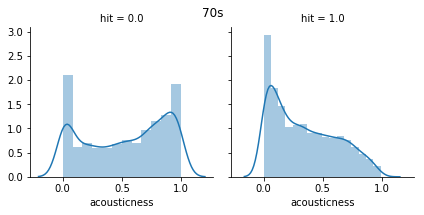

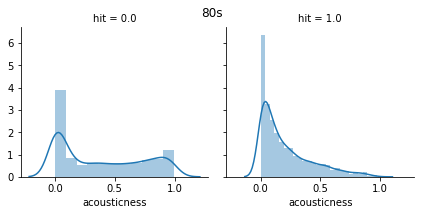

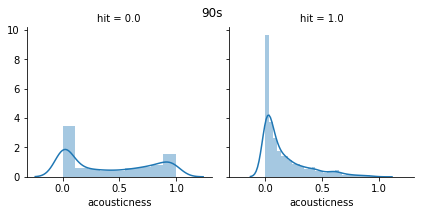

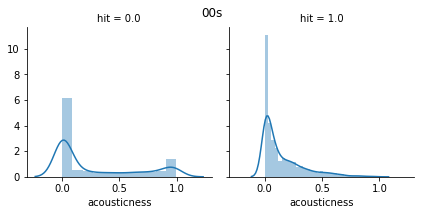

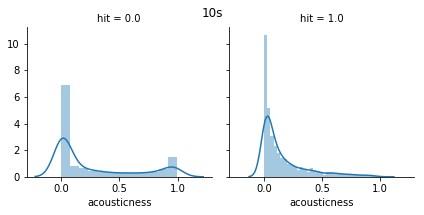

In [9]:
for i in spotify_data.decade.unique().tolist():
    g = sns.FacetGrid(spotify_data[spotify_data['decade']==i], col="hit")
    g.map(sns.distplot, "acousticness", label = i)
    g.fig.suptitle(i)

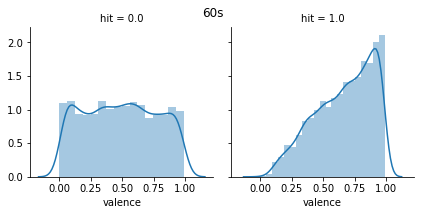

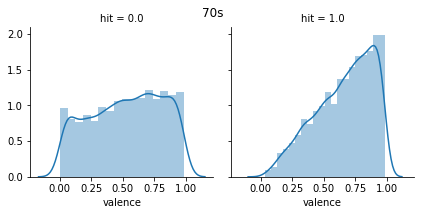

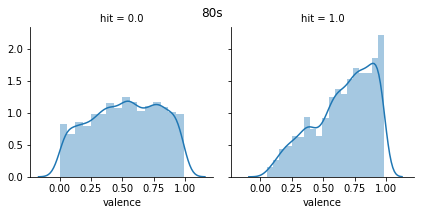

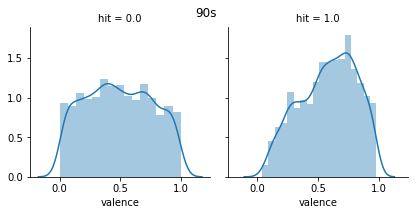

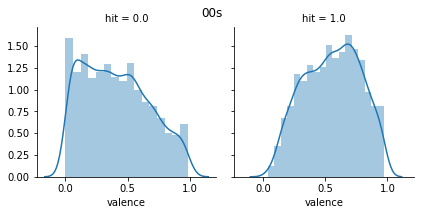

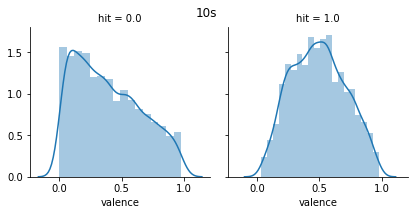

In [10]:
for i in spotify_data.decade.unique().tolist():
    g = sns.FacetGrid(spotify_data[spotify_data['decade']==i], col="hit")
    g.map(sns.distplot, "valence", label = i)
    g.fig.suptitle(i)

In [11]:
spotify_data.decade.unique().tolist()

['60s', '70s', '80s', '90s', '00s', '10s']

##### All the distributions aren't normal danceability looks like a normal distribution

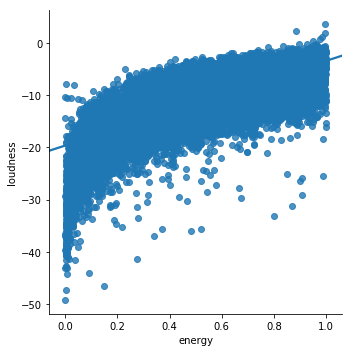

In [12]:
sns.lmplot( x="energy", y="loudness", data=spotify_data)

#### Insights:
* We see some pattern differences in time that indicates that explains how the taste in songs changes over decades. Keeping this in mind building models by segmenting them on decade could be valuable. 

* Since the initial analysis suggest loudness and energy are correlated. Dropping loudness and utilizing energy for modeling.

* Even though energy might have some correlationship with acousticness but it is comparitively less. Also, the analysis indicate some value we observe the change in taste of music over the decades. 

* Hit songs are happy or sad any impact on hit with mood? Valence value gives that information on plotting we see that historically a big number of hit song have values towards 1. In more recent times we see more normal distribution in valence for the hits. However, a lot of songs that aren't hit have lower valence.

* Similarly liveness, danceability etc should be tested if there is value in them. 

#### Future analysis
* Does artist popularity affect hit songs? 
* extract featuring artist and primary artist. Understanding impact of featured artist. 
     * eg: 50 Cent Featuring Justin Timberlake & Timbaland

#### Data Pre-processing + Modelling

In [14]:
features = ['danceability',
            'energy',
            'mode',
            'valence',
            'acousticness',
            'speechiness',
            'instrumentalness',
            'liveness',
            'tempo',
            'chorus_hit']

In [15]:
normalize = False
scale     = True
model = XGBClassifier()
segment_data = spotify_data[spotify_data.hit.notna()].copy()
x = segment_data[features]
y = segment_data["hit"]
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.33)
if (scale == True):
    scaler     = preprocessing.MinMaxScaler().fit(x_train)
    x_train    = scaler.transform(x_train)
    x_validate = scaler.transform(x_validate)
if (normalize == True):
    qt = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
    x_train    = qt.fit_transform(x_train)
    x_validate = qt.fit_transform(x_validate)

clf = model.fit(x_train, y_train)

y_predicted_val   = clf.predict(x_validate)
y_predicted_train = clf.predict(x_train)

cm = confusion_matrix(y_validate, y_predicted_val )
print(cm)
print("train AUC")
print(roc_auc_score(y_train, y_predicted_train))
print("test AUC")
print(roc_auc_score(y_validate, y_predicted_val))

[[3867 1665]
 [ 824 4685]]
train AUC
0.7775391774456127
test AUC
0.7747252179336593


In [24]:
def score_test_val(features,model):
    '''
    :param  features : variables that the model would utilize for training 
    :param  model    : binary classification model
    :param  normalize: If x distribution should be converted to gaussian distribution
    :param  scale    : If x should be scaled to a specific range
    :return roc_auc_score    : training data
    :return roc_auc_score    : validation data
    :return confusion matrix : validation data
    
    '''
    Y_Train_True           =  []
    Y_Train_Predicted      =  []
    Y_Validation_True      =  []
    Y_Validation_Predicted =  []
    for i in spotify_data.decade.unique().tolist():
        segment_data = spotify_data[spotify_data.hit.notna()][spotify_data.decade == i].copy()
        x = segment_data[features]
        y = segment_data["hit"]
        x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.33)
            
        if (type(model) != xgboost.sklearn.XGBClassifier): 
            clf = Pipeline([('scaler', preprocessing.MinMaxScaler()),
                             ('normalizer', preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)),
                             ('model', model)]).fit(x_train, y_train)
            filename = i+'_model.sav'
            joblib.dump(clf, filename)
        
        
        if (type(model) == xgboost.sklearn.XGBClassifier):
            clf = model.fit(x_train, y_train)
            clf.save_model(i+'_model.json')


        y_predicted_val   = clf.predict(x_validate)
        y_predicted_train = clf.predict(x_train)

        Y_Validation_Predicted += y_predicted_val.tolist()
        Y_Train_Predicted      += y_predicted_train.tolist()
        Y_Train_True           += y_train.tolist()      
        Y_Validation_True      += y_validate.tolist()   

    return roc_auc_score(Y_Train_True , Y_Train_Predicted), roc_auc_score(Y_Validation_True, Y_Validation_Predicted), confusion_matrix(Y_Validation_True, Y_Validation_Predicted)

        


### Results below have AUC score for training data , Validation data and confusion matrix for validation data for different methods

In [25]:
score_test_val(features, LogisticRegression())

(0.7336155476000473, 0.7328475528140299, array([[3943, 1533],
        [1416, 4151]]))

In [26]:
score_test_val(features, MLPClassifier(alpha = 0.0001))

(0.8221320505292574, 0.786321961685514, array([[4032, 1454],
        [ 902, 4655]]))

In [27]:
score_test_val(features, XGBClassifier())

(0.8272290045090116, 0.7923326404922321, array([[3959, 1501],
        [ 784, 4799]]))